# Tutorial on self-normalizing networks on the MNIST data set: multi-layer perceptrons

*Author:* Kajetan Schweighofer, 2021

In [1]:
import os
import copy
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# load data and preprocess

path = os.path.join(".", "dataset", "mnist")
os.makedirs(path, exist_ok=True)

# convert PIL image to tensor and normalize
transform = transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)

## Functions

### Model

In [3]:

    
class ExpActivation(nn.Module):
    """
    Applies elementwise activation based on exponential function

    Inspired by squared relu, but with bounded range and gradient for better stability
    """
    def __init__(self):
        super(ExpActivation, self).__init__()

    def forward(self, input):
        # print("using exponential activation")
        return torch.exp(input)

class ReEUActivation(nn.Module):
    """
    Applies elementwise activation based on rectified exponential unit function
    f(x) = exp(x) if x > 0 else 0
    """
    def __init__(self):
        super(ReEUActivation, self).__init__()

    def forward(self, input):
        return torch.exp(nn.functional.relu(input)) - 1.0
    
    
class SoftmaxActivation(nn.Module):
    """
    Applies the Softmax activation function elementwise
    """
    def __init__(self):
        super(SoftmaxActivation, self).__init__()

    def forward(self, input):
        return nn.functional.softmax(input, dim=-1)
    
    

In [4]:
class MLP(nn.Module):

    def __init__(self, in_features: int, out_features: int, p_drop=0.2, act_fn: str="relu"):
        super(MLP, self).__init__()

        if act_fn == "selu":
            activation = nn.SELU()
        elif act_fn == "relu":
            activation = nn.ReLU()
        elif act_fn == "exp":
            activation = ExpActivation()
        elif act_fn == "softmax":
            activation = SoftmaxActivation()
        elif act_fn == "reu":
            activation = ReEUActivation()
        elif act_fn == "elu":
            activation = nn.ELU()
        else:
            raise ValueError(f"Unsupported activation function: {act_fn}")
        # activation = nn.SELU() if act_fn == "selu" else nn.ReLU()
        # dropout = nn.AlphaDropout(p=p_drop) if act_fn == "selu" else nn.Dropout(p=p_drop) # use standard dropout for all activations
        dropout = nn.Dropout(p=p_drop)
        self.net = nn.Sequential(
            nn.Flatten(),   # flatten input image from batchx1x28x28 to batchx784
            nn.Linear(in_features=in_features, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=out_features)
        )

        if act_fn == "selu":
            for param in self.net.parameters():
                # biases zero
                if len(param.shape) == 1:
                    nn.init.constant_(param, 0)
                # others using lecun-normal initialization
                else:
                    nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        return self.net(x)

### Accuracy metric

In [5]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)

### Training / Evaluation methods

In [6]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):

    for x, y in data:
        x = x.to(next(network.parameters()).device)

        # y_hat = network.forward(x)
        y_hat = network.forward(x).cpu()
        loss = metric(y_hat, y)
        yield loss

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: torch.optim.Optimizer) -> list:

    network.train()

    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        opt.zero_grad()
        try:
            err.backward()
            opt.step()
        except:
            print('error in update step')
    return errs

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> float:

    network.eval()

    performance = []
    for p in _forward(network, data, metric):
        p = np.array(p)
        performance.append(p.item())
    return np.mean(performance).item()


def fit(network: nn.Module, trainloader: DataLoader, valloader: DataLoader,
          testloader: DataLoader, epochs: int, lr: float):
    optimizer = torch.optim.SGD(params=network.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    accuracy = Accuracy()

    train_losses, val_losses, accuracies = [], [], []

    # performance before training
    val_losses.append(evaluate(network=network, data=valloader, metric=ce))

    pbar = tqdm(range(epochs))
    for ep in pbar:
        # update network
        tl = update(network=network, data=trainloader, loss=ce, opt=optimizer)
        train_losses.extend(tl)
        vl = evaluate(network=network, data=valloader, metric=ce)
        val_losses.append(vl)
        ac = evaluate(network=network, data=valloader, metric=accuracy)

        if len(accuracies) == 0 or ac > max(accuracies):
            # here we would store the model on disc for early stopping
            best_model = copy.deepcopy(network)

        accuracies.append(ac)

        print(f"train loss: {round(np.mean(tl), 4):.4f}, "
              f"val loss: {round(vl, 4):.4f}, "
              f"accuracy: {round(ac * 100, 2):.2f}%")

        pbar.set_description_str(desc=f"Epoch {ep+1}")

    # evaluate on best model obtained throughout training
    acc = evaluate(network=best_model, data=testloader, metric=accuracy)

    print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

    return train_losses, val_losses, accuracies, acc

## Training

### Hyperparameters

In [7]:
epochs = 20
lr = 1e-3
batch_size = 128
num_workers = 4
p_drop = 0.05

### Create Dataloaders

In [8]:
# obtain validation set (1/6 of train data to be equal to size of test data)
rng = np.random.default_rng(seed=42)
val_inds = rng.choice(np.arange(len(train)), size=len(train)//6, replace=False)
train_inds = np.delete(np.arange(len(train)), val_inds)

trainloader = DataLoader(Subset(train, indices=train_inds),
                         batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
valloader = DataLoader(Subset(train, indices=val_inds),
                       batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [ ]:
# ReLU training

# 28x28 = 784 input images for 10 classes
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="relu").to(device)
rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

TypeError: MLP.__init__() got an unexpected keyword argument 'use_selu'

In [ ]:
# SELU training
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="selu").to(device)
stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [00:12<04:05, 12.90s/it]

train loss: 1.1719, val loss: 0.6603, accuracy: 82.59%


Epoch 2:  10%|█         | 2/20 [00:26<03:58, 13.25s/it]

train loss: 0.5977, val loss: 0.5076, accuracy: 85.84%


Epoch 3:  15%|█▌        | 3/20 [00:39<03:44, 13.18s/it]

train loss: 0.4956, val loss: 0.4457, accuracy: 87.47%


Epoch 4:  20%|██        | 4/20 [00:52<03:31, 13.20s/it]

train loss: 0.4450, val loss: 0.4108, accuracy: 88.48%


Epoch 5:  25%|██▌       | 5/20 [01:05<03:17, 13.19s/it]

train loss: 0.4128, val loss: 0.3869, accuracy: 88.95%


Epoch 6:  30%|███       | 6/20 [01:18<03:03, 13.13s/it]

train loss: 0.3915, val loss: 0.3691, accuracy: 89.41%


Epoch 7:  35%|███▌      | 7/20 [01:31<02:48, 12.99s/it]

train loss: 0.3737, val loss: 0.3561, accuracy: 89.86%


Epoch 8:  40%|████      | 8/20 [01:44<02:34, 12.90s/it]

train loss: 0.3621, val loss: 0.3454, accuracy: 90.12%


Epoch 9:  45%|████▌     | 9/20 [01:57<02:22, 12.96s/it]

train loss: 0.3497, val loss: 0.3356, accuracy: 90.35%


Epoch 10:  50%|█████     | 10/20 [02:10<02:09, 12.97s/it]

train loss: 0.3402, val loss: 0.3282, accuracy: 90.52%


Epoch 11:  55%|█████▌    | 11/20 [02:23<01:57, 13.04s/it]

train loss: 0.3329, val loss: 0.3209, accuracy: 90.73%


Epoch 12:  60%|██████    | 12/20 [02:36<01:44, 13.06s/it]

train loss: 0.3264, val loss: 0.3144, accuracy: 91.02%


Epoch 13:  65%|██████▌   | 13/20 [02:49<01:31, 13.13s/it]

train loss: 0.3203, val loss: 0.3102, accuracy: 91.14%


Epoch 14:  70%|███████   | 14/20 [03:03<01:19, 13.33s/it]

train loss: 0.3135, val loss: 0.3053, accuracy: 91.14%


Epoch 15:  75%|███████▌  | 15/20 [03:18<01:07, 13.60s/it]

train loss: 0.3069, val loss: 0.3004, accuracy: 91.30%


Epoch 16:  80%|████████  | 16/20 [03:32<00:55, 13.81s/it]

train loss: 0.3020, val loss: 0.2967, accuracy: 91.43%


Epoch 17:  85%|████████▌ | 17/20 [03:46<00:41, 13.82s/it]

train loss: 0.2992, val loss: 0.2927, accuracy: 91.51%


Epoch 18:  90%|█████████ | 18/20 [03:59<00:27, 13.65s/it]

train loss: 0.2933, val loss: 0.2892, accuracy: 91.66%


Epoch 19:  95%|█████████▌| 19/20 [04:12<00:13, 13.63s/it]

train loss: 0.2882, val loss: 0.2860, accuracy: 91.75%


Epoch 20: 100%|██████████| 20/20 [04:26<00:00, 13.32s/it]

train loss: 0.2873, val loss: 0.2823, accuracy: 91.86%


Final accuracy on testset: 92.05%


In [ ]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="exp").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

softtl, softvl, softaccs, softacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [00:12<04:05, 12.90s/it]

train loss: 0.9992, val loss: 0.4571, accuracy: 87.41%


Epoch 2:  10%|█         | 2/20 [00:26<03:54, 13.03s/it]

train loss: 0.4733, val loss: 0.3388, accuracy: 90.67%


Epoch 3:  15%|█▌        | 3/20 [00:39<03:45, 13.24s/it]

train loss: 0.3794, val loss: 0.2892, accuracy: 91.68%


Epoch 4:  20%|██        | 4/20 [00:53<03:37, 13.62s/it]

train loss: 0.3320, val loss: 0.2615, accuracy: 92.64%


Epoch 5:  25%|██▌       | 5/20 [01:07<03:23, 13.54s/it]

train loss: 0.2952, val loss: 0.2417, accuracy: 93.16%


Epoch 6:  30%|███       | 6/20 [01:21<03:14, 13.87s/it]

train loss: 0.2734, val loss: 0.2196, accuracy: 93.87%


Epoch 7:  35%|███▌      | 7/20 [01:35<02:58, 13.71s/it]

train loss: 0.2522, val loss: 0.2096, accuracy: 93.93%


Epoch 8:  40%|████      | 8/20 [01:47<02:40, 13.38s/it]

train loss: 0.2372, val loss: 0.1953, accuracy: 94.51%


Epoch 9:  45%|████▌     | 9/20 [02:00<02:26, 13.30s/it]

train loss: 0.2266, val loss: 0.1887, accuracy: 94.71%


Epoch 10:  50%|█████     | 10/20 [02:13<02:10, 13.08s/it]

train loss: 0.2093, val loss: 0.1829, accuracy: 94.82%


Epoch 11:  55%|█████▌    | 11/20 [02:26<01:56, 12.96s/it]

train loss: 0.2039, val loss: 0.1715, accuracy: 94.99%


Epoch 12:  60%|██████    | 12/20 [02:38<01:42, 12.83s/it]

train loss: 0.1932, val loss: 0.1659, accuracy: 95.17%


Epoch 13:  65%|██████▌   | 13/20 [02:51<01:29, 12.79s/it]

train loss: 0.1852, val loss: 0.1665, accuracy: 95.18%


Epoch 14:  70%|███████   | 14/20 [03:03<01:16, 12.72s/it]

train loss: 0.1769, val loss: 0.1552, accuracy: 95.59%


Epoch 15:  75%|███████▌  | 15/20 [03:16<01:03, 12.69s/it]

train loss: 0.1704, val loss: 0.1513, accuracy: 95.74%


Epoch 16:  80%|████████  | 16/20 [03:29<00:51, 12.76s/it]

train loss: 0.1659, val loss: 0.1507, accuracy: 95.78%


Epoch 17:  85%|████████▌ | 17/20 [03:42<00:38, 12.74s/it]

train loss: 0.1598, val loss: 0.1461, accuracy: 95.89%


Epoch 18:  90%|█████████ | 18/20 [03:54<00:25, 12.70s/it]

train loss: 0.1545, val loss: 0.1423, accuracy: 95.91%


Epoch 19:  95%|█████████▌| 19/20 [04:01<00:10, 10.90s/it]

train loss: 0.1483, val loss: 0.1378, accuracy: 96.15%


Epoch 20: 100%|██████████| 20/20 [04:13<00:00, 12.70s/it]

train loss: 0.1442, val loss: 0.1351, accuracy: 96.24%


Final accuracy on testset: 96.57%


In [ ]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="elu").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

elutl, eluvl, eluaccs, eluacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [00:12<04:05, 12.90s/it]

train loss: 2.0644, val loss: 1.8096, accuracy: 70.54%


Epoch 2:  10%|█         | 2/20 [00:27<04:14, 14.14s/it]

train loss: 1.5862, val loss: 1.3644, accuracy: 75.86%


Epoch 3:  15%|█▌        | 3/20 [00:44<04:18, 15.21s/it]

train loss: 1.1986, val loss: 1.0427, accuracy: 79.13%


Epoch 4:  20%|██        | 4/20 [00:57<03:48, 14.30s/it]

train loss: 0.9411, val loss: 0.8401, accuracy: 82.38%


Epoch 5:  25%|██▌       | 5/20 [01:10<03:26, 13.76s/it]

train loss: 0.7802, val loss: 0.7126, accuracy: 84.27%


Epoch 6:  30%|███       | 6/20 [01:23<03:09, 13.50s/it]

train loss: 0.6761, val loss: 0.6281, accuracy: 85.41%


Epoch 7:  35%|███▌      | 7/20 [01:36<02:53, 13.34s/it]

train loss: 0.6049, val loss: 0.5691, accuracy: 86.24%


Epoch 8:  40%|████      | 8/20 [01:48<02:37, 13.16s/it]

train loss: 0.5544, val loss: 0.5262, accuracy: 86.89%


Epoch 9:  45%|████▌     | 9/20 [02:01<02:23, 13.08s/it]

train loss: 0.5157, val loss: 0.4938, accuracy: 87.39%


Epoch 10:  50%|█████     | 10/20 [02:15<02:12, 13.25s/it]

train loss: 0.4864, val loss: 0.4671, accuracy: 87.81%


Epoch 11:  55%|█████▌    | 11/20 [02:28<01:57, 13.10s/it]

train loss: 0.4638, val loss: 0.4476, accuracy: 88.16%


Epoch 12:  60%|██████    | 12/20 [02:41<01:45, 13.22s/it]

train loss: 0.4441, val loss: 0.4311, accuracy: 88.36%


Epoch 13:  65%|██████▌   | 13/20 [02:55<01:33, 13.31s/it]

train loss: 0.4291, val loss: 0.4174, accuracy: 88.62%


Epoch 14:  70%|███████   | 14/20 [03:08<01:20, 13.40s/it]

train loss: 0.4164, val loss: 0.4057, accuracy: 88.82%


Epoch 15:  75%|███████▌  | 15/20 [03:22<01:07, 13.57s/it]

train loss: 0.4040, val loss: 0.3957, accuracy: 88.99%


Epoch 16:  80%|████████  | 16/20 [03:36<00:54, 13.65s/it]

train loss: 0.3952, val loss: 0.3873, accuracy: 89.12%


Epoch 17:  85%|████████▌ | 17/20 [03:51<00:42, 14.11s/it]

train loss: 0.3865, val loss: 0.3794, accuracy: 89.34%


Epoch 18:  90%|█████████ | 18/20 [04:04<00:27, 13.78s/it]

train loss: 0.3786, val loss: 0.3725, accuracy: 89.42%


Epoch 19:  95%|█████████▌| 19/20 [04:20<00:14, 14.48s/it]

train loss: 0.3717, val loss: 0.3669, accuracy: 89.55%


Epoch 20: 100%|██████████| 20/20 [04:35<00:00, 13.78s/it]

train loss: 0.3664, val loss: 0.3618, accuracy: 89.69%


Final accuracy on testset: 90.35%


### Plot results

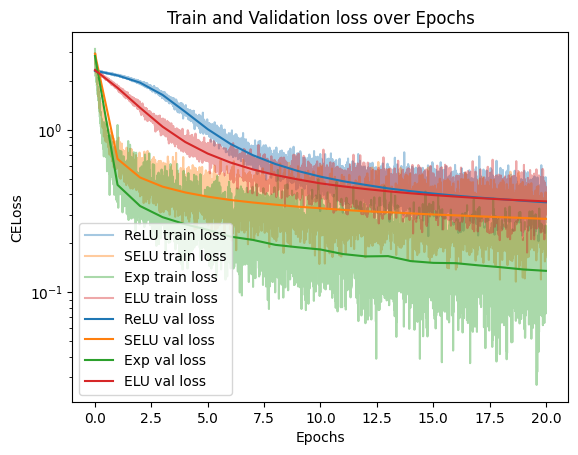

In [ ]:
plt.figure()
plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
plt.plot(np.asarray(range(len(softtl))) / len(trainloader), softtl, alpha=0.4, label="Exp train loss")
plt.plot(np.asarray(range(len(elutl))) / len(trainloader), elutl, alpha=0.4, label="ELU train loss")
plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
plt.plot(range(len(svl)), svl, color="C1", label="SELU val loss")
plt.plot(range(len(softvl)), softvl, color="C2", label="Exp val loss")
plt.plot(range(len(eluvl)), eluvl, color="C3", label="ELU val loss")
plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.yscale("log")
plt.legend()
plt.show()

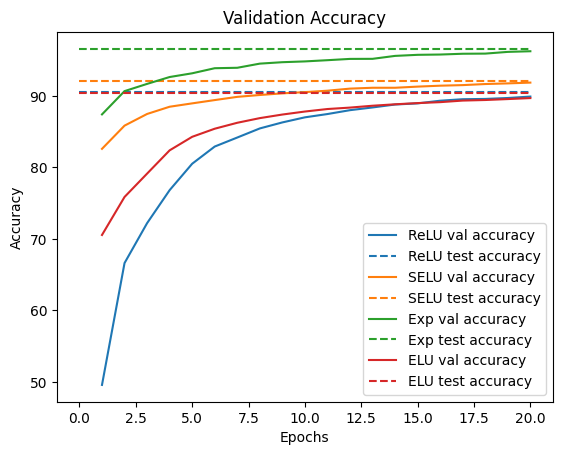

In [ ]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
plt.plot(range(1, len(softaccs)+1), [a*100 for a in softaccs], label="Exp val accuracy")
plt.hlines(y=softacc*100, xmin=0, xmax=len(softaccs), colors="C2", linestyles="dashed", label="Exp test accuracy")
plt.plot(range(1, len(eluaccs)+1), [a*100 for a in eluaccs], label="ELU val accuracy")
plt.hlines(y=eluacc*100, xmin=0, xmax=len(eluaccs), colors="C3", linestyles="dashed", label="ELU test accuracy")

plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()